# LAPD 'homeless' crimes: 2010-present

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
# data exported from '00-lapd-crimes-processing.ipynb'
src = pd.read_feather('/Users/mhustiles/data/data/LA/crimes.feather')

In [3]:
src.head()

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category
0,4,100100501,2010-01-03,2010-01-02,2100,1,Central,176,1,122,"Rape, attempted",0400,47,female,H,103,Alley,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,122,nan,nan,nan,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010,1,2,1,Saturday,January,hispanic,21,00,pt_one_violent
1,5,100100506,2010-01-05,2010-01-04,1650,1,Central,162,1,442,Shoplifting - petty theft ($950 & under),0344 1402,23,male,B,404,Department store,nan,None,AA,adult_arrest,442,nan,nan,nan,700 W 7TH ST,None,34.0480,-118.2577,2010,1,4,1,Monday,January,black,16,50,pt_one_property
2,6,100100508,2010-01-08,2010-01-07,2005,1,Central,182,1,330,Burglary from vehicle,0344,46,male,H,101,Street,nan,None,IC,invest_cont,330,nan,nan,nan,PICO BL,GRAND AV,34.0389,-118.2643,2010,1,7,1,Thursday,January,hispanic,20,05,pt_one_property
3,7,100100509,2010-01-09,2010-01-08,2100,1,Central,157,1,230,"Assault with deadly weapon, aggravated assault",0416,51,male,B,710,Other premise,500.0,Unknown weapon/other weapon,AA,adult_arrest,230,nan,nan,nan,500 CROCKER ST,None,34.0435,-118.2427,2010,1,8,1,Friday,January,black,21,00,pt_one_violent
4,8,100100510,2010-01-09,2010-01-09,0230,1,Central,171,1,230,"Assault with deadly weapon, aggravated assault",0400 0416,30,male,H,108,Parking lot,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,230,nan,nan,nan,800 W OLYMPIC BL,None,34.0450,-118.2640,2010,1,9,1,Saturday,January,hispanic,02,30,pt_one_violent


---

## Limit dataframe to serious crimes — the type reported to FBI

In [4]:
crimes = src[src['part_type'] == '1']

### Cases involving suspects or victimes defined by LAPD as 'homeless'

In [5]:
mocrimes = crimes.dropna(subset=['modus_operandi_code'])

In [6]:
mocodes = pd.read_csv('mo_codes.csv')
mocodes.head()

,mo_code,mo_code_description
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer


In [7]:
# Chief Beck orders departmentwide focus on coding in 2016
# MO Code 1218 is to be used when a victim is homeless
# MO Code 2004 is to be used when a suspect is homeless
mocodes_homeless = mocodes[mocodes['mo_code_description'].str.lower().str.contains('homeless')]
mocodes_homeless.head()

,mo_code,mo_code_description
361,1218,Victim was Homeless/Transient
521,2004,Suspect is homeless/transient


### Limit homeless crime data to recent years to account for coding issues

In [8]:
homeless_dates = ['2016', '2017', '2018', '2019']

### Various filters

In [9]:
#Homeless people codes
homeless_victims = crimes[(crimes['modus_operandi_code'].str.contains('1218', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_suspects = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_homicides = homeless_victims[(homeless_victims['crime_code_description']\
                    .str.contains('Criminal homicide', na=False))\
                    & (homeless_victims['year'].isin(homeless_dates))]

In [10]:
homeless_victims_women = homeless_victims[homeless_victims['victim_sex'] == 'female']

### How many cases do we have involving homeless people? 

In [11]:
len(homeless_victims_women)

3272

In [12]:
len(homeless_victims)

9304

In [13]:
len(homeless_suspects)

15382

In [14]:
homeless_victims.columns

Index(['index', 'record_id', 'date_reported', 'date_occurred', 'time_occurred',
       'division', 'division_name', 'reporting_district', 'part_type',
       'crime_code', 'crime_code_description', 'modus_operandi_code',
       'victim_age', 'victim_sex', 'victim_descent', 'premises_code',
       'premises_description', 'weapon_code', 'weapon_description',
       'status_code', 'status_code_description', 'crm_cd_1', 'crm_cd_2',
       'crm_cd_3', 'crm_cd_4', 'address', 'cross_street', 'latitude',
       'longitude', 'year', 'quarter', 'day', 'month', 'weekday', 'monthname',
       'descent_description', 'hour', 'minute', 'part_category'],
      dtype='object')

---

### Group by cases involving homeless victims

In [15]:
homeless_victims_years = homeless_victims.groupby\
(['division_name']).agg('size').reset_index(name='total')

### Group by cases involving homeless suspects

In [16]:
homeless_suspects_years = homeless_suspects.groupby\
(['division_name']).agg('size').reset_index(name='total')
homeless_suspects_years.head()

,division_name,total
0,77th Street,411
1,Central,3572
2,Devonshire,352
3,Foothill,351
4,Harbor,532


---

### Homeless homicides

In [17]:
homeless_homicides.head()

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category
664336,1228859,160212396,2016-06-13,2016-06-13,1900,2,Rampart,261,1,110,Criminal homicide,1218 1402 2004,24,male,W,506,Abandoned building abandoned house,506.0,Fire,AA,adult_arrest,110,648,998.0,nan,2400 W 8TH ST,None,34.0563,-118.2810,2016,2,13,6,Monday,June,white,19,00,pt_one_violent
664465,1229088,160212397,2016-06-13,2016-06-13,1900,2,Rampart,261,1,110,Criminal homicide,1218 1402 2004,18,female,W,506,Abandoned building abandoned house,506.0,Fire,AA,adult_arrest,110,648,998.0,nan,2400 W 8TH ST,None,34.0563,-118.2810,2016,2,13,6,Monday,June,white,19,00,pt_one_violent
668738,1236675,160212395,2016-06-13,2016-06-13,1900,2,Rampart,261,1,110,Criminal homicide,1218 1402 2004,44,female,H,506,Abandoned building abandoned house,506.0,Fire,AA,adult_arrest,110,648,998.0,nan,2400 W 8TH ST,None,34.0563,-118.2810,2016,2,13,6,Monday,June,hispanic,19,00,pt_one_violent
678442,1253667,161906109,2016-02-08,2016-02-08,2238,19,Mission,1982,1,110,Criminal homicide,0411 1218,38,male,H,108,Parking lot,207.0,Other knife,AA,adult_arrest,110,nan,nan,nan,8700 PARTHENIA PL,None,34.2286,-118.4644,2016,1,8,2,Monday,February,hispanic,22,38,pt_one_violent
682441,1260742,161104730,2016-01-17,2016-01-17,0600,11,Northeast,1159,1,110,Criminal homicide,0302 1100 1402 0430 1218,19,male,H,108,Parking lot,102.0,Hand gun,IC,invest_cont,110,998,nan,nan,4700 N FIGUEROA ST,None,34.1002,-118.2038,2016,1,17,1,Sunday,January,hispanic,06,00,pt_one_violent


In [18]:
homeless_homicides_years = homeless_homicides.groupby\
(['year','division_name', 'premises_description','weapon_description']).agg('size').reset_index(name='total')

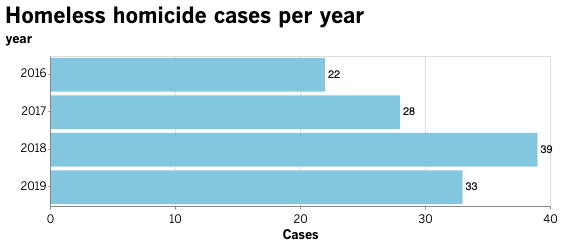

In [19]:
chart_homeless_homicides_years = alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('year:N', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_homicides_years_text = chart_homeless_homicides_years.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)

(chart_homeless_homicides_years + chart_homeless_homicides_years_text).properties(height=150, width=500, title='Homeless homicide cases per year')

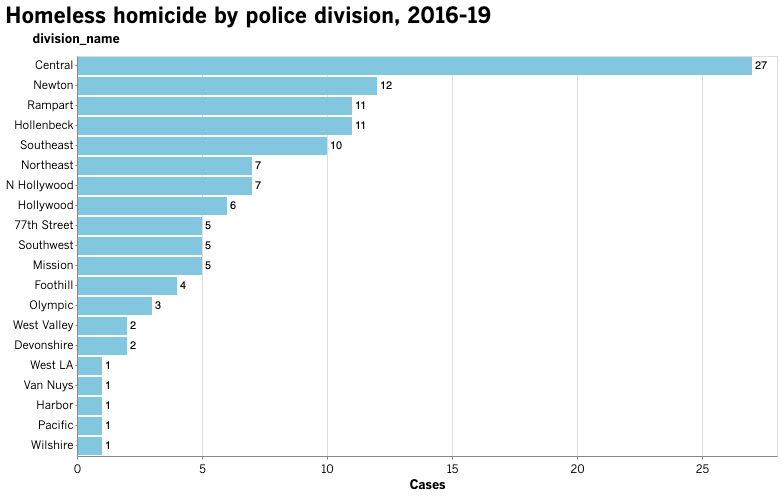

In [20]:
chart_homeless_divisions = alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('division_name:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_divisions_text = chart_homeless_divisions.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)


(chart_homeless_divisions + chart_homeless_divisions_text)\
.properties(height=400, width=700, title='Homeless homicide by police division, 2016-19')

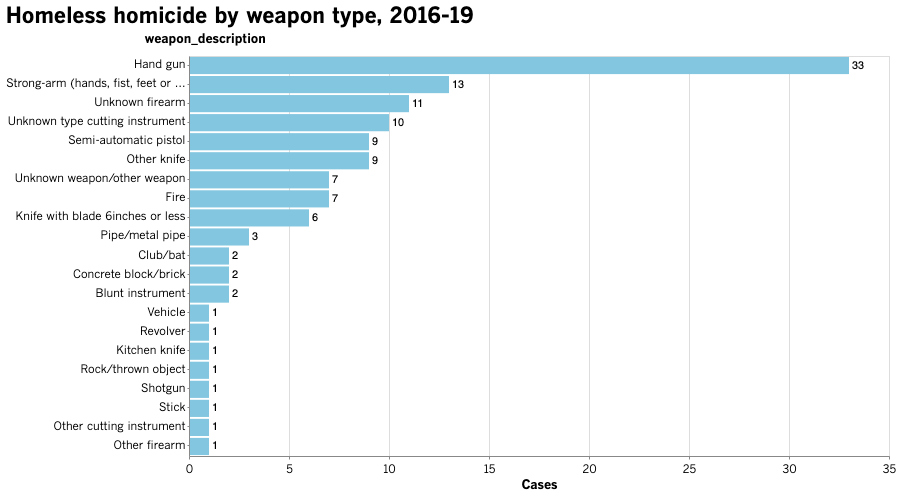

In [21]:
chart_homeless_weapon = alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('weapon_description:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_weapon_text = chart_homeless_weapon.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)

(chart_homeless_weapon + chart_homeless_weapon_text)\
    .properties(height=400, width=700, title='Homeless homicide by weapon type, 2016-19')

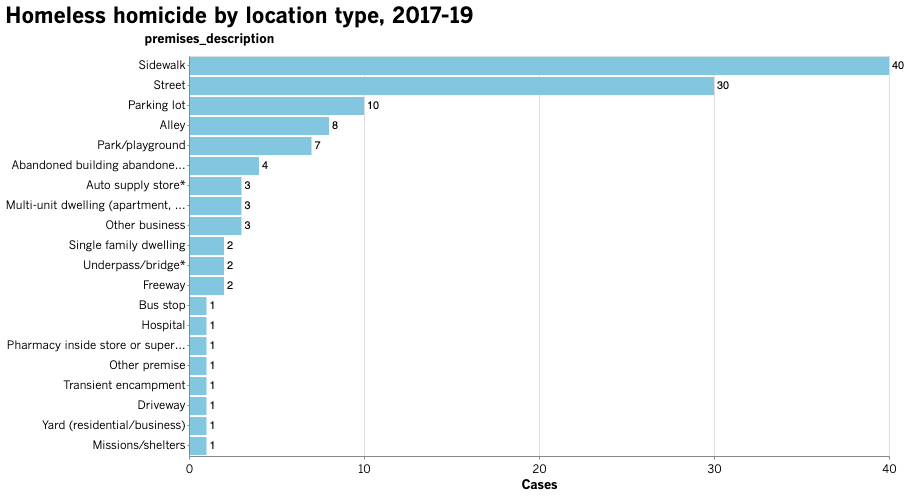

In [22]:
chart_homeless_location = alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('premises_description:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_location_text = chart_homeless_location.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)

(chart_homeless_location + chart_homeless_location_text)\
.properties(height=400, width=700, title='Homeless homicide by location type, 2017-19')

---

## Homeless victims

In [23]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head()

,year,division_name,total
64,2019,Central,1178
43,2018,Central,976
1,2016,Central,514
22,2017,Central,454
55,2018,Rampart,223


In [24]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head(10)

,year,division_name,total
64,2019,Central,1178
43,2018,Central,976
1,2016,Central,514
22,2017,Central,454
55,2018,Rampart,223
51,2018,Newton,198
72,2019,Newton,185
76,2019,Rampart,183
48,2018,Hollywood,168
34,2017,Rampart,166


### Where do crimes involving homeless victims occur? 

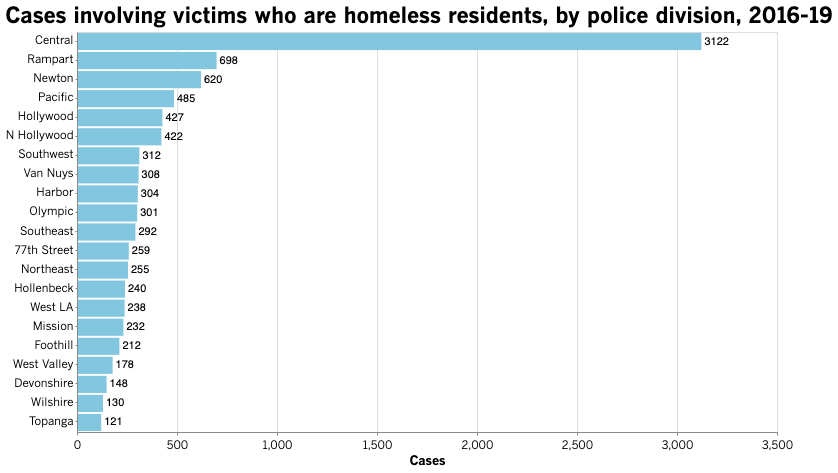

In [25]:
chart_homeless_victims = alt.Chart(homeless_victims_years).mark_bar().encode(
    y=alt.Y('division_name:N', title='',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_victims_text = chart_homeless_victims.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)


(chart_homeless_victims + chart_homeless_victims_text)\
.properties(height=400, width=700, title='Cases involving victims who are homeless residents, by police division, 2016-19')

In [26]:
homeless_victims['division_name'].value_counts('normalize').round(2)*100

Central        34.0
Rampart         8.0
Newton          7.0
Pacific         5.0
Hollywood       5.0
N Hollywood     5.0
Southwest       3.0
Van Nuys        3.0
Harbor          3.0
Olympic         3.0
Southeast       3.0
77th Street     3.0
Northeast       3.0
Hollenbeck      3.0
West LA         3.0
Mission         2.0
Foothill        2.0
West Valley     2.0
Devonshire      2.0
Wilshire        1.0
Topanga         1.0
Name: division_name, dtype: float64

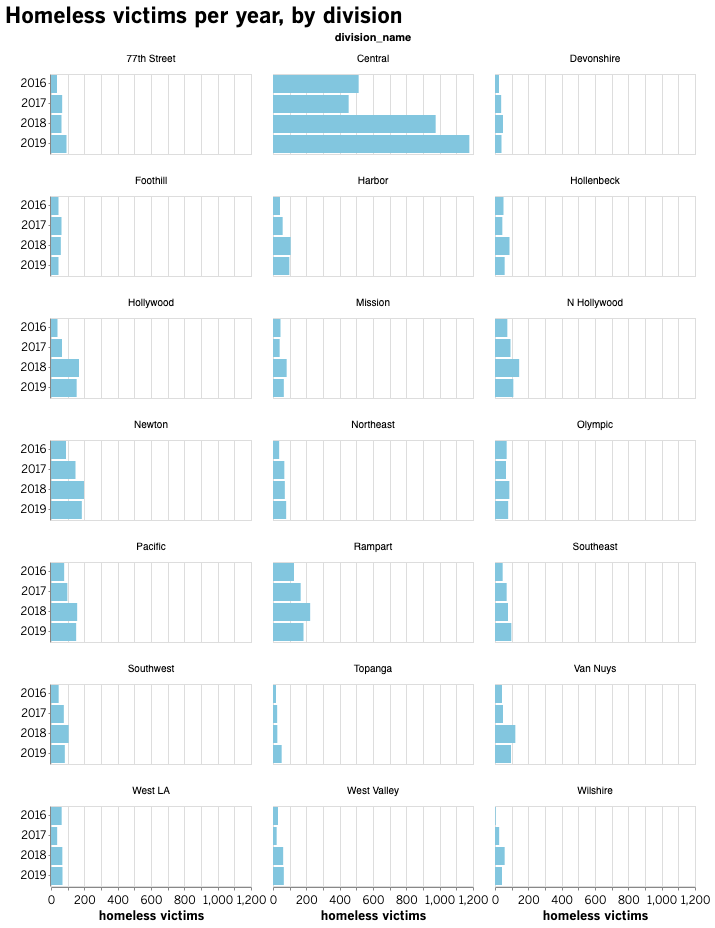

In [27]:
alt.Chart(homeless_year_victim).mark_bar().encode(
    y=alt.Y('year:N', title='', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("mean(total):Q", title="homeless victims", axis=alt.Axis(format='', tickCount=10)),
    facet='division_name:N'
).properties(height=80, width=200, columns=3, title='Homeless victims per year, by division')

### What types of crimes are most common for homeless victims?

In [28]:
homeless_cases_victim = homeless_victims.groupby(['crime_code_description', 'part_type', 'victim_sex'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

### Homeless victims in central

In [29]:
homeless_victims_central = homeless_victims[homeless_victims['division_name'] == 'Central']

In [30]:
homeless_cases_victim_central = homeless_victims_central.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [31]:
homeless_cases_victim_central.head()

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",954
27,Theft plain - petty ($950 & under),753
17,Robbery,499
11,Intimate partner - aggravated assault,149
5,Brandish weapon,132


---

In [32]:
homeless_cases_suspect = homeless_suspects.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [33]:
homeless_cases_suspect.head(10)

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",4193
23,Robbery,2455
26,Shoplifting - petty theft ($950 & under),2301
34,Theft plain - petty ($950 & under),1062
7,Burglary,1049
6,Brandish weapon,1023
16,Intimate partner - aggravated assault,724
3,Attempted robbery,482
8,Burglary from vehicle,308
36,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",288


--- 

### What are the population breakdowns for men and women?

In [34]:
homeless_female_pop_share19 = 30.1
homeless_male_pop_share19 = 67.3
homeless_male_pop19 = 24360
homeless_female_pop19 = 10845

homeless_female_pop_share19 = 31
homeless_male_pop_share19 = 67
homeless_male_pop18 = 20907
homeless_female_pop18 = 9577

city_female_pop_share = 50.5
city_male_pop_share = 45.5
city_female_pop = 2015180
city_male_pop = 1815657

### What types of crimes do female homeless residents encounter?

In [35]:
vic_sex_pivot = pd.pivot_table(homeless_cases_victim, values='total', \
                       index=['crime_code_description'],columns=['victim_sex'], \
                                        aggfunc=np.sum, fill_value=0).reset_index()

In [36]:
vic_sex_pivot['total_all'] = (vic_sex_pivot['female'] + \
                vic_sex_pivot['male'] + \
                vic_sex_pivot['unknown'])

In [37]:
vic_sex_pivot['female_share_all'] = ((vic_sex_pivot['female'] / \
                                           vic_sex_pivot['total_all'])*100).round(2)

In [38]:
vic_sex_pivot['male_share_all'] = ((vic_sex_pivot['male'] / \
                                           vic_sex_pivot['total_all'])*100).round(2)

In [39]:
vic_sex_pivot.sort_values(by='total_all', ascending=False).head(10)

victim_sex,crime_code_description,female,male,unknown,total_all,female_share_all,male_share_all
2,"Assault with deadly weapon, aggravated assault",770,2714,4,3488,22.08,77.81
20,Robbery,404,1156,2,1562,25.86,74.01
31,Theft plain - petty ($950 & under),601,868,2,1471,40.86,59.01
12,Intimate partner - aggravated assault,458,164,0,622,73.63,26.37
6,Brandish weapon,136,258,0,394,34.52,65.48
19,"Rape, forcible",379,6,0,385,98.44,1.56
32,"Theft, person",87,139,0,226,38.50,61.50
33,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",87,127,1,215,40.47,59.07
3,Attempted robbery,48,161,1,210,22.86,76.67
11,Criminal homicide,13,109,0,122,10.66,89.34


In [40]:
homeless_vic_sex_pivot = pd.pivot_table(homeless_cases_victim, values='total', \
                       index=['crime_code_description'],columns=['victim_sex'], \
                                        aggfunc=np.sum, fill_value=0).reset_index()

In [41]:
homeless_vic_sex_pivot['total_homeless'] = (homeless_vic_sex_pivot['female'] + \
                homeless_vic_sex_pivot['male'] + \
                homeless_vic_sex_pivot['unknown'])

In [42]:
homeless_vic_sex_pivot['female_share_homeless'] = ((homeless_vic_sex_pivot['female'] / \
                                           homeless_vic_sex_pivot['total_homeless'])*100).round(2)

In [43]:
homeless_vic_sex_pivot['male_share_homeless'] = ((homeless_vic_sex_pivot['male'] / \
                                           homeless_vic_sex_pivot['total_homeless'])*100).round(2)

In [44]:
homeless_vic_sex_pivot.sort_values(by='total_homeless', ascending=False).head(20)

victim_sex,crime_code_description,female,male,unknown,total_homeless,female_share_homeless,male_share_homeless
2,"Assault with deadly weapon, aggravated assault",770,2714,4,3488,22.08,77.81
20,Robbery,404,1156,2,1562,25.86,74.01
31,Theft plain - petty ($950 & under),601,868,2,1471,40.86,59.01
12,Intimate partner - aggravated assault,458,164,0,622,73.63,26.37
6,Brandish weapon,136,258,0,394,34.52,65.48
19,"Rape, forcible",379,6,0,385,98.44,1.56
32,"Theft, person",87,139,0,226,38.50,61.50
33,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",87,127,1,215,40.47,59.07
3,Attempted robbery,48,161,1,210,22.86,76.67
11,Criminal homicide,13,109,0,122,10.66,89.34


In [45]:
female_share_homeless_all = pd.merge(vic_sex_pivot, homeless_vic_sex_pivot, on='crime_code_description')

In [46]:
female_share_homeless_all_trimmed = female_share_homeless_all[[ 'crime_code_description',\
                               'total_homeless', 'female_share_all', 'female_share_homeless']]

In [47]:
female_share_homeless_all_trimmed.sort_values(by='total_homeless', ascending=False).head(20)

victim_sex,crime_code_description,total_homeless,female_share_all,female_share_homeless
2,"Assault with deadly weapon, aggravated assault",3488,22.08,22.08
20,Robbery,1562,25.86,25.86
31,Theft plain - petty ($950 & under),1471,40.86,40.86
12,Intimate partner - aggravated assault,622,73.63,73.63
6,Brandish weapon,394,34.52,34.52
19,"Rape, forcible",385,98.44,98.44
32,"Theft, person",226,38.50,38.50
33,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",215,40.47,40.47
3,Attempted robbery,210,22.86,22.86
11,Criminal homicide,122,10.66,10.66


--- 

### Import homeless population by LA Times neighborhood

In [48]:
homeless_pop = \
pd.read_csv('/Users/mhustiles/data/github/notebooks/homeless-restrictions-raw/output\
/homeless-apportioned-totals-by-neighborhood.csv')

In [49]:
homeless_pop = homeless_pop[homeless_pop['totpeople'] > 1]

### Relate homeless victim/suspect incident data to LA neighborhoods, not just police geography

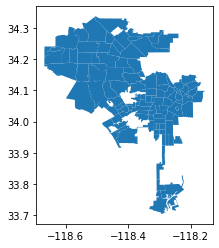

In [50]:
# Read Los Angeles Times neighborhoods
hoods = gpd.read_file('input/custom-la-hoods-skid-row.geojson')
hoods.plot()

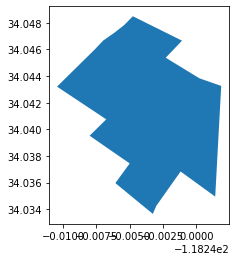

In [51]:
skidrow = hoods[hoods['name'] == 'Skid Row']
skidrow.plot()

### Convert homeless victims dataframe to geodataframe, set CRS, join with 'hoods 

In [52]:
homeless_victims_gdf = gpd.GeoDataFrame(homeless_victims, \
    geometry=gpd.points_from_xy(homeless_victims.longitude, homeless_victims.latitude))
homeless_victims_gdf.crs = ({'init':'epsg:4326'})
homeless_victims_hoods = gpd.sjoin(homeless_victims_gdf, hoods, op = 'within')

### Convert homeless suspects dataframe to geodataframe, set CRS, join with 'hoods 

In [53]:
homeless_suspects_gdf = gpd.GeoDataFrame(homeless_suspects, \
    geometry=gpd.points_from_xy(homeless_suspects.longitude, homeless_suspects.latitude))
homeless_suspects_gdf.crs = ({'init':'epsg:4326'})
homeless_suspects_hoods = gpd.sjoin(homeless_suspects_gdf, hoods, op = 'within')

### Group by hood name

In [54]:
homeless_victims_hoods_grouped = homeless_victims_hoods.groupby(['name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [55]:
homeless_suspects_hoods_grouped = homeless_suspects_hoods.groupby(['name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [56]:
homeless_suspects_hoods_grouped.head(10)

,name,total
23,Downtown,2503
86,Skid Row,1257
47,Hollywood,715
109,Westlake,706
98,Van Nuys,575
99,Venice,545
67,North Hollywood,515
52,Koreatown,381
25,East Hollywood,328
9,Boyle Heights,267


In [57]:
homeless_victims_hoods_grouped.head(10)

,name,total
85,Skid Row,1932
22,Downtown,1417
108,Westlake,465
46,Hollywood,370
98,Venice,330
97,Van Nuys,279
51,Koreatown,236
66,North Hollywood,226
24,East Hollywood,175
45,Historic South-Central,170


### Calculate crime rate among homeless victims

In [58]:
homeless_victims_hoods_merged = pd.merge(homeless_victims_hoods_grouped, homeless_pop, on='name')

In [59]:
homeless_victims_hoods_merged.sort_values(by='totpeople', ascending=False)

,name,total,unsheltered,unshelteredoutside,totpeople
0,Skid Row,1932,1560.699515,1511.234336,3483.296138
1,Downtown,1417,2477.656050,2298.862691,2993.002167
2,Westlake,465,1239.655588,921.219987,1755.307232
3,Hollywood,370,1191.539096,634.890246,1454.445295
9,Historic South-Central,170,944.710611,673.731808,1193.057813
12,Sun Valley,122,740.138565,245.318142,1152.144565
4,Venice,330,1091.534800,567.493195,1101.539811
10,Boyle Heights,159,869.935630,512.306282,1071.937630
5,Van Nuys,279,675.235038,327.020823,755.125837
15,Vermont Square,105,319.691371,184.630879,665.101111


In [60]:
homeless_victims_hoods_merged['rate'] = \
(homeless_victims_hoods_merged['total'] / (homeless_victims_hoods_merged['totpeople']/100)).round(1)

In [61]:
homeless_victims_hoods_merged.sort_values(by='rate', ascending=False)

,name,total,unsheltered,unshelteredoutside,totpeople,rate
81,Toluca Lake,16,12.367069,9.539124,12.367069,129.4
101,Larchmont,4,3.229615,3.129461,3.229615,123.9
96,Hollywood Hills West,6,6.521895,5.432202,6.521895,92.0
70,Lake Balboa,21,23.329680,6.488715,24.167177,86.9
100,Century City,5,6.952370,3.265168,6.952370,71.9
36,Northridge,48,84.921058,23.224370,85.088915,56.4
0,Skid Row,1932,1560.699515,1511.234336,3483.296138,55.5
19,North Hills,81,124.911940,72.748118,149.904106,54.0
67,Brentwood,23,20.599239,13.978384,44.658182,51.5
72,Atwater Village,20,38.944272,29.636641,38.944272,51.4


### Calculate breaks for crime rate

In [62]:
breaks_rate \
= jenkspy.jenks_breaks(homeless_victims_hoods_merged.rate, nb_class=7)

In [63]:
breaks_rate

[2.1, 12.4, 21.9, 32.0, 44.3, 56.4, 92.0, 129.4]

In [64]:
def get_group_rate(value):
    for i, b in enumerate(breaks_rate):
        if value <= breaks_rate[i+1]:
            return i

In [65]:
homeless_victims_hoods_merged['rate_score'] = homeless_victims_hoods_merged.rate.apply(get_group_rate)

### Calculate breaks for total crimes

In [66]:
breaks_crimes \
= jenkspy.jenks_breaks(homeless_victims_hoods_merged.total, nb_class=7)

In [67]:
breaks_crimes

[1.0, 36.0, 87.0, 175.0, 279.0, 465.0, 1417.0, 1932.0]

In [68]:
def get_group_crimes(value):
    for i, b in enumerate(breaks_crimes):
        if value <= breaks_crimes[i+1]:
            return i

In [69]:
homeless_victims_hoods_merged['crimes_score'] = homeless_victims_hoods_merged.total.apply(get_group_crimes)

In [70]:
homeless_victims_hoods_merged.sort_values(by='crimes_score', ascending=False).head()

,name,total,unsheltered,unshelteredoutside,totpeople,rate,rate_score,crimes_score
0,Skid Row,1932,1560.699515,1511.234336,3483.296138,55.5,4,6
1,Downtown,1417,2477.656050,2298.862691,2993.002167,47.3,4,5
2,Westlake,465,1239.655588,921.219987,1755.307232,26.5,2,4
3,Hollywood,370,1191.539096,634.890246,1454.445295,25.4,2,4
4,Venice,330,1091.534800,567.493195,1101.539811,30.0,2,4


### Merge homeless victim rate by 'hoods back to the 'hoods geodataframe

In [71]:
homeless_victims_maps = hoods.merge(homeless_victims_hoods_merged, on='name', how='left')

In [72]:
homeless_victims_maps.to_file('output/homeless_victims_maps.geojson', driver='GeoJSON')

In [73]:
geojson = json.loads(homeless_victims_maps.to_json())

In [74]:
features = alt.Data(values=geojson['features'])

In [75]:
base = alt.Chart(features).mark_geoshape(
    stroke='white',
    fill='#e6e6e6',
    strokeWidth=0.1
).encode().properties(
    width=400,
    height=600
)

In [76]:
geoshape = alt.Chart(features).mark_geoshape(
    fill='#e6e6e6',
    stroke='white'
)

In [77]:
rate = geoshape.encode(
    color=alt.Color(
        "properties.rate_score:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
)

crimesall = geoshape.encode(
    color=alt.Color(
        "properties.crimes_score:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
)

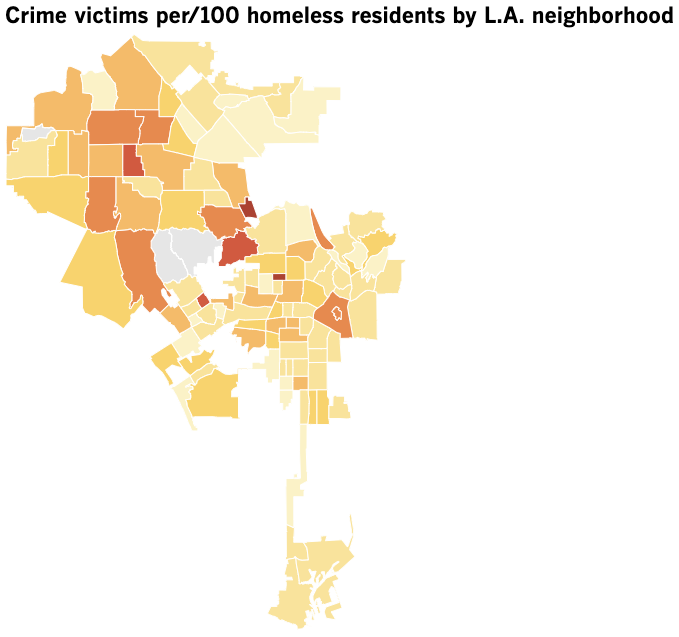

In [78]:
(base + rate).properties(title="Crime victims per/100 homeless residents by L.A. neighborhood").configure_view(
    strokeWidth=0
)

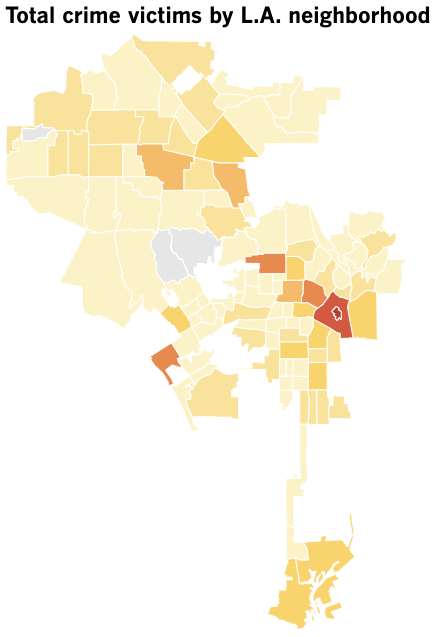

In [79]:
(base + crimesall).properties(title="Total crime victims by L.A. neighborhood").configure_view(
    strokeWidth=0
)

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [80]:
all_crimes_grouped = crimes.groupby(['crime_code_description', 'victim_sex'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [81]:
all_crimes_grouped.head(10)

,crime_code_description,victim_sex,total
26,Burglary from vehicle,male,87047
23,Burglary,male,81388
117,Theft plain - petty ($950 & under),male,76276
25,Burglary from vehicle,female,70454
7,"Assault with deadly weapon, aggravated assault",male,65349
116,Theft plain - petty ($950 & under),female,64638
22,Burglary,female,56978
78,Robbery,male,54444
132,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",male,40395
87,Shoplifting - petty theft ($950 & under),male,31950


### Which crimes are most common for homeless victims?

In [82]:
homeless_crimes_grouped = homeless_victims.groupby(['crime_code_description', 'victim_sex'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [83]:
homeless_cases_victim.head(10)

,crime_code_description,part_type,victim_sex,total
4,"Assault with deadly weapon, aggravated assault",1,male,2714
38,Robbery,1,male,1156
60,Theft plain - petty ($950 & under),1,male,868
3,"Assault with deadly weapon, aggravated assault",1,female,770
59,Theft plain - petty ($950 & under),1,female,601
23,Intimate partner - aggravated assault,1,female,458
37,Robbery,1,female,404
35,"Rape, forcible",1,female,379
13,Brandish weapon,1,male,258
24,Intimate partner - aggravated assault,1,male,164


### Places where crimes against homeless residents occur?

In [84]:
# homeless victims
homeless_places = homeless_victims.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
# all crimes
places = crimes.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [85]:
homeless_places.head()

,premises_description,total
132,Sidewalk,2834
139,Street,2619
116,Parking lot,543
103,"Multi-unit dwelling (apartment, duplex, etc)",403
115,Park/playground,383


In [86]:
places.head()

,premises_description,total
273,Street,349886
262,Single family dwelling,143478
229,Parking lot,112576
207,"Multi-unit dwelling (apartment, duplex, etc)",83698
261,Sidewalk,60125


### Where are homeless victims cases occuring in LAPD's divisions? 

In [87]:
homeless_divisions = homeless_victims.groupby(['division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [88]:
homeless_divisions.head(10)

,division_name,total
1,Central,3122
13,Rampart,698
9,Newton,620
12,Pacific,485
6,Hollywood,427
8,N Hollywood,422
15,Southwest,312
17,Van Nuys,308
4,Harbor,304
11,Olympic,301


### Which days of the week?

In [89]:
# homeless victims
homeless_weekdays = homeless_victims.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
# all crimes
weekdays = crimes.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

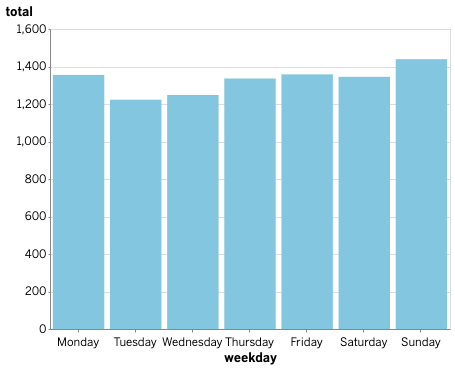

In [90]:
homeless_weekdays.head(7)
alt.Chart(homeless_weekdays).mark_bar().encode(
    x=alt.X('weekday:N', 
sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y='total:Q'
).properties(width=400, height=300)

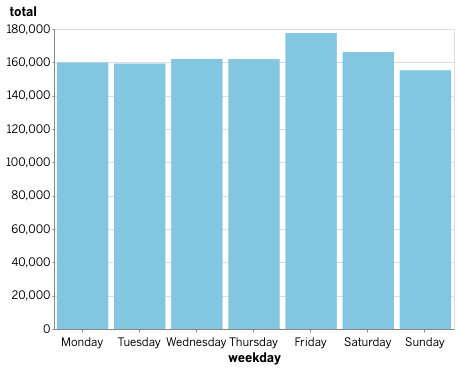

In [91]:
weekdays.head(7)
alt.Chart(weekdays).mark_bar().encode(
    x=alt.X('weekday:N', 
sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y='total:Q'
).properties(width=400, height=300)

---